In [1]:
%matplotlib inline
import numpy as np
from scipy import integrate, interpolate
import matplotlib.pyplot as plt
np.random.SEED = 42

p_posterior is proportional to the posterior probability of alpha and beta given the observed data.  The model is that $logit(\theta)=\alpha+dose*\beta$, where theta is the probablity of death for the log drug concentration dose.

$$logit(p)=\log\left( \frac{p}{1-p} \right) =\log(p)-\log(1-p)=-\log\left( \frac{1}{p} - 1\right)$$

The $logit$ function is often used to stretch the value space of a variable that has a range from 0 to 1 (for example a probability).

As you can see below, for each dose the likelihood of the data to be observed $deaths_i$ given the probability of death $\theta_i$ and the number of tries $n_i$:

$$P( deaths_{i} \mid n_{i},\theta_{i}) \propto  \theta_{i}^{deaths_{i}}(1-\theta_{i})^{n_{i}-deaths_{i}}$$

The combined likelihood is the product of all experimental outcomes:

$$P( \{deaths_{i}\} \mid \{n_{i},\theta_{i}\}) \propto  \prod_{i}\theta_{i}^{deaths_{i}}(1-\theta_{i})^{n_{i}-deaths_{i}}$$

In order to use the function with alpha, beta being two-dimensional matrices and dose,obs_deaths and n being one-dimensional arrays, I was forced to interate over dose and then take the product over the first axis.  Let me know if there is an easier and more elegant way.

In [2]:
n_samples = 5 * np.ones(4, dtype=int)
dose = np.array([-0.86,-0.3,-.05,.73])
deaths = np.array([0,1,3,5])

In [3]:
def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

In [4]:
def p_posterior(alpha,beta,dose,obs_deaths,n):
    p=[]
    for dose_i,obs_deaths_i,n_i in zip(dose,obs_deaths,n):
        theta_i = invlogit(alpha+beta*dose_i)
        p.append(theta_i**obs_deaths_i*(1-theta_i)**(n_i-obs_deaths_i))
    p=np.array(p)
    return np.prod(p,axis=0)

In [5]:
# interlude
a = [1,2,3,4]
b = [5,6,7,8]
for i in range(4):
    print(a[i],b[i],a[i]*b[i])

1 5 5
2 6 12
3 7 21
4 8 32


In [6]:
for aa,bb in zip(a,b):
    print(aa,bb)

1 5
2 6
3 7
4 8


In [7]:
list(zip(a,b,a))[2]

(3, 7, 3)

In [8]:
for i,aa in enumerate(a):
    print(i,aa)

0 1
1 2
2 3
3 4


In [9]:
# end of interlude
delta = 0.1
alpha = np.arange(-5.0,10.0+delta, delta)
beta = np.arange(-10,40+delta,delta)
ALPHA, BETA = np.meshgrid(alpha,beta)
P = p_posterior(ALPHA,BETA,dose,deaths,n_samples)

(0, 25)

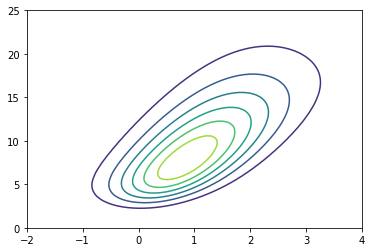

In [10]:
plt.figure()
CS = plt.contour(ALPHA,BETA,P)
plt.xlim((-2,4))
plt.ylim((0,25))

In [11]:
alpha_marg = np.mean(P,axis=0)
beta_marg = np.mean(P,axis=1)

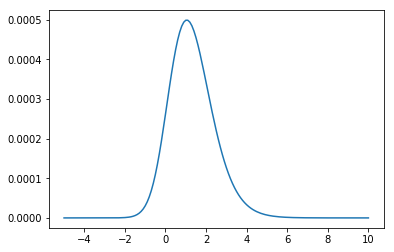

In [12]:
plt.plot(alpha,alpha_marg)

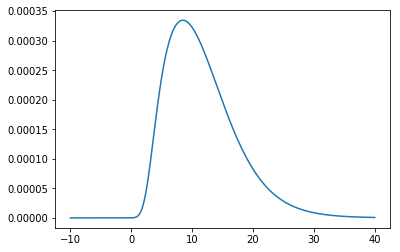

In [13]:
plt.plot(beta,beta_marg)

In [14]:
def inv_cdf(pdf,x):
    cdf_pdf = [integrate.simps(pdf[:i+1],x[:i+1]) for i in range(len(x)-1)]
    cdf_pdf = np.array([0]+cdf_pdf)
    cdf_pdf = cdf_pdf/cdf_pdf[-1]
    return interpolate.interp1d(cdf_pdf,x)

In [15]:
inv_cdf_alpha = inv_cdf(alpha_marg,alpha)

In [16]:
n=1000
sample_alpha = np.random.random_sample(n)
sample_beta = np.random.random_sample(n)

alpha_sampling = inv_cdf_alpha(sample_alpha)

beta_sampling = []

for alp,bet in zip(alpha_sampling,sample_beta):
    beta_dis = p_posterior(alp,beta,dose,deaths,n_samples)
    b_sample = inv_cdf(beta_dis,beta)(bet)
    beta_sampling.append(b_sample)
    
beta_sampling = np.array(beta_sampling)

ld50 = -alpha_sampling/beta_sampling
    

(array([  1.,   0.,   0.,   0.,   0.,   3.,   1.,   0.,   1.,   2.,   9.,
         32.,  91., 138., 218., 186., 138.,  97.,  37.,  13.,  15.,   8.,
          2.,   3.,   1.,   0.,   1.,   0.,   2.,   1.]),
 array([-0.69278083, -0.65469558, -0.61661033, -0.57852509, -0.54043984,
        -0.50235459, -0.46426934, -0.4261841 , -0.38809885, -0.3500136 ,
        -0.31192835, -0.27384311, -0.23575786, -0.19767261, -0.15958736,
        -0.12150212, -0.08341687, -0.04533162, -0.00724637,  0.03083887,
         0.06892412,  0.10700937,  0.14509462,  0.18317986,  0.22126511,
         0.25935036,  0.29743561,  0.33552085,  0.3736061 ,  0.41169135,
         0.4497766 ]),
 <a list of 30 Patch objects>)

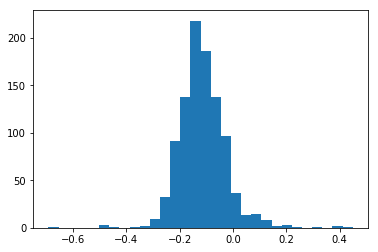

In [17]:
plt.hist(ld50,bins=30)

In [18]:
print(np.percentile(ld50,(2.5,25,50,75,97.5)))

[-0.26365259 -0.16660973 -0.12072956 -0.06911361  0.0854991 ]


In [31]:
alpha0 = alpha_sampling[-1]
beta0 = beta_sampling[-1]
p0 = p_posterior(alpha0,beta0,dose,deaths,n_samples)

alpha_mcmc = [alpha0]
beta_mcmc = [beta0]

n = 10000

steps = np.random.multivariate_normal([0,0],[[1,0],[0,2]],n)
accepts = 0

for step in steps:
    alpha1 = alpha0 + step[0]
    beta1 = beta0 + step[1]
    p1 = p_posterior(alpha1,beta1,dose,deaths,n_samples)
    a = min(1.0,p1/p0)
    if a==1.0 or a>np.random.rand():
        alpha0 = alpha1
        beta0 = beta1
        p0 = p1
        accepts +=1
    alpha_mcmc.append(alpha0)
    beta_mcmc.append(beta0)
    
print("acceptance rate: ",accepts/n*100.0)
alpha_mcmc = np.array(alpha_mcmc)
beta_mcmc = np.array(beta_mcmc)
ld50 = -alpha_mcmc/beta_mcmc

acceptance rate:  62.39


(array([1.97288689e-03, 0.00000000e+00, 1.97288689e-03, 0.00000000e+00,
        3.94577379e-03, 0.00000000e+00, 1.97288689e-03, 4.34035117e-02,
        1.04563005e-01, 4.26143569e-01, 1.16400327e+00, 2.80347228e+00,
        4.51593810e+00, 4.88486795e+00, 3.05402891e+00, 1.52898734e+00,
        6.11594937e-01, 3.29472111e-01, 1.18373214e-01, 4.34035117e-02,
        2.76204165e-02, 2.36746427e-02, 7.89154758e-03, 3.15661903e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.97288689e-03]),
 array([-0.7771878 , -0.72650573, -0.67582365, -0.62514158, -0.5744595 ,
        -0.52377743, -0.47309535, -0.42241328, -0.3717312 , -0.32104913,
        -0.27036706, -0.21968498, -0.16900291, -0.11832083, -0.06763876,
        -0.01695668,  0.03372539,  0.08440747,  0.13508954,  0.18577162,
         0.23645369,  0.28713577,  0.33781784,  0.38849992,  0.43918199,
         0.48986407,  0.54054614,  0.59122822,  0.64191029,  0.69259236,
         0.74327

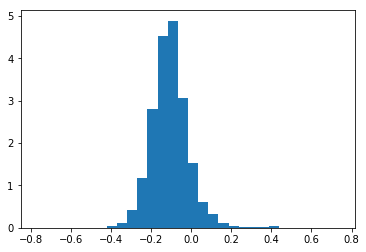

In [27]:
plt.hist(ld50,bins=30,density=True)

In [28]:
print(np.percentile(ld50,(2.5,25,50,75,97.5)))

[-0.27681945 -0.16456023 -0.11067539 -0.05754182  0.09273736]
